## Train and evaluate Model I
### Libraries

In [1]:

# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/AppliedDeepLearning')

In [5]:
import torch
import sys
import pandas as pd
# import torchvision
import numpy as np
%matplotlib inline
import skimage.io as io
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu
from tqdm.auto import tqdm
from loader import FlickrDataset,preprocessing_transforms,get_data_loader,denormalize,Padding
from vocab import Vocabulary
from csv import DictWriter
from model import EncoderCNN,DecoderRNN
from model_utils import train, validate,clip_gradient,save_checkpoint,evaluate_test
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import time
import math
import sys
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# # import sys
# del sys.modules["model"]
# del sys.modules['model_utils']

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Building Vocabulary and Loading our data


In [6]:
run_colab = False
if run_colab:
        vocab = Vocabulary(vocab_file = './drive/MyDrive/AppliedDeepLearning/vocab10000.txt',vocab_size = 10000)
        vocab.load_vocab()
        val_data = FlickrDataset('./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/val.csv', vocab = vocab,images_folder='./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/images', transform=preprocessing_transforms(),train_mode = False)
        train_data = FlickrDataset('./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/train.csv', vocab = vocab,images_folder='./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/images', transform=preprocessing_transforms(),train_mode=True)
        test_data = FlickrDataset('./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/test.csv', vocab = vocab,images_folder='./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/images', transform=preprocessing_transforms(),train_mode = False)
else:
    vocab = Vocabulary(vocab_file = './vocab10000.txt',vocab_size = 10000)
    vocab.load_vocab()
    val_data = FlickrDataset('./flickr30k_processed/val.csv', vocab = vocab,images_folder='./flickr30k_processed/images', transform=preprocessing_transforms(),train_mode = False)
    train_data = FlickrDataset('./flickr30k_processed/train.csv', vocab = vocab,images_folder='./flickr30k_processed/images', transform=preprocessing_transforms(),train_mode=True)
    test_data = FlickrDataset('./flickr30k_processed/test.csv', vocab = vocab,images_folder='./flickr30k_processed/images', transform=preprocessing_transforms(),train_mode = False)

In [7]:
train_loader= DataLoader(dataset=train_data, batch_size= 32,
                          num_workers=2,pin_memory=True, shuffle=True,  collate_fn= Padding(pad_idx=0,batch_first=True,train_mode = True))

val_loader = DataLoader(dataset=val_data, batch_size= 32,
                          num_workers=2,pin_memory=True, shuffle=True,  collate_fn= Padding(pad_idx=0,batch_first=True,train_mode = False))
test_loader = DataLoader(dataset=test_data, batch_size= 32,
                          num_workers=2,pin_memory=True, shuffle=True,  collate_fn= Padding(pad_idx=0,batch_first=True,train_mode = False))

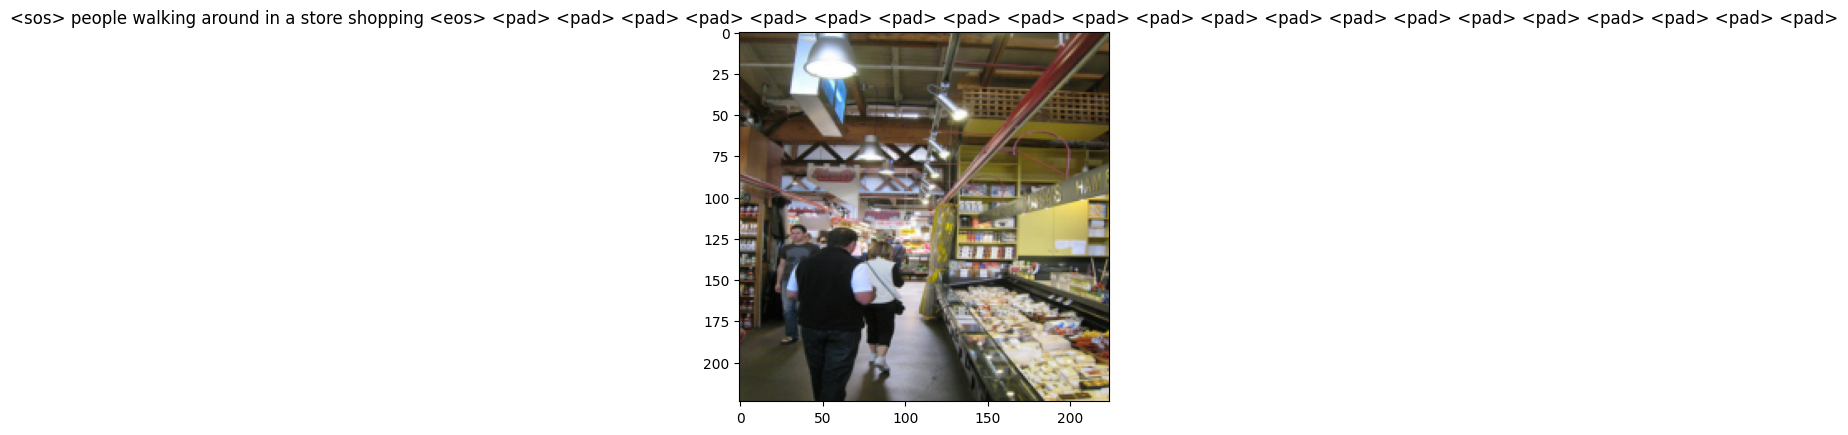

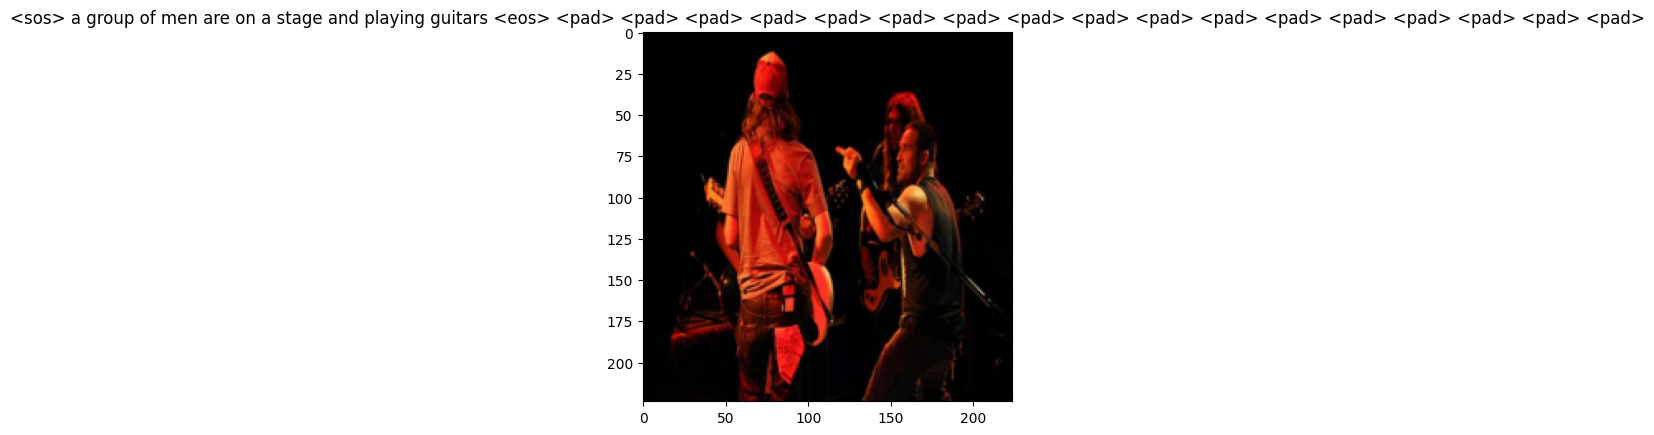

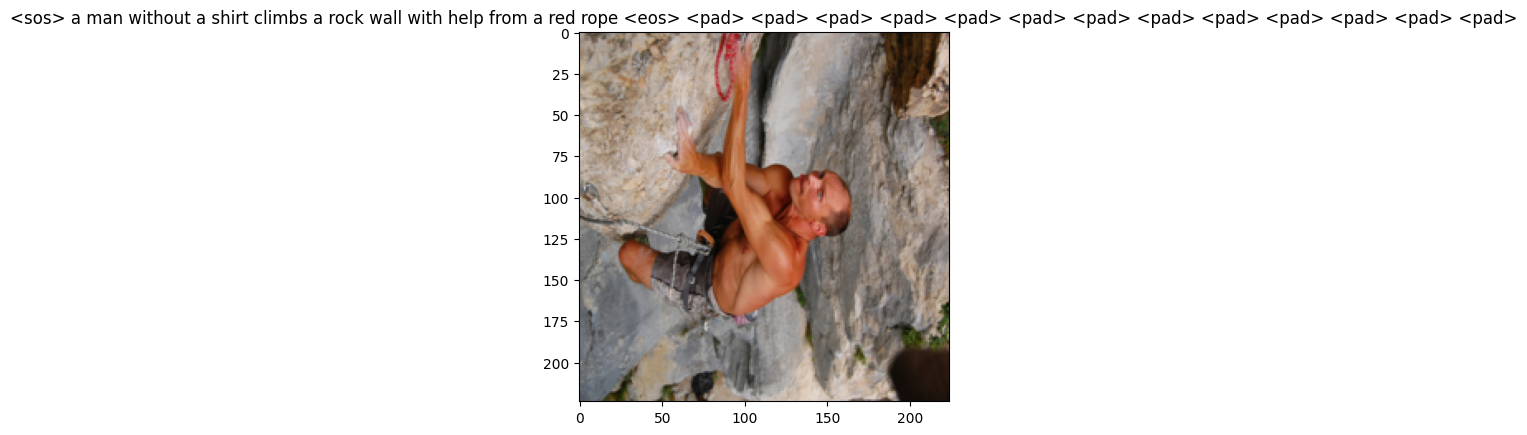

In [ ]:
# some examples from train set
i= 0
x, y,l = next(iter(train_loader))
for image, caption,length in zip(x, y,l):
    image = denormalize(image)
    caption = [vocab.idx_to_word(int(word_id)) for word_id in caption]
    caption = ' '.join(word for word in caption)
    plt.imshow(image)
    plt.title(caption)
    plt.show()
    plt.pause(1)
    i+=1
    if i ==3:
        break

<sos> two black and white dogs look toward something in the air while running in a grassy field <eos>
<sos> two dogs change direction in an uncut field surrounded by low brush <eos>
<sos> two black and white dogs in a field of flowers and grass <eos>
<sos> two dogs run in a field looking at an unseen frisbee <eos>
<sos> two black and white dogs running in a flowery field <eos>


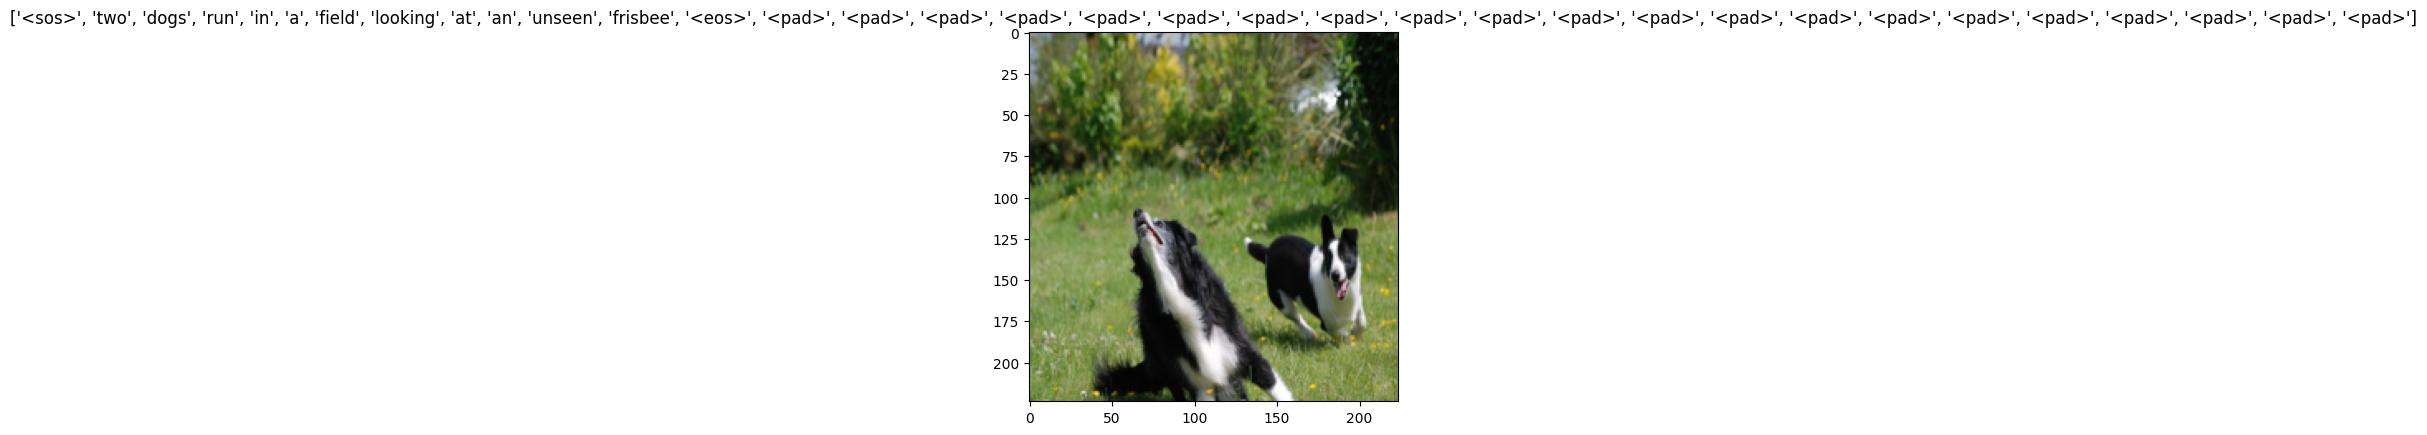

<sos> a woman wearing a blue shirt opens a present which is a green hat <eos>
<sos> a blondhaired woman wearing a blue shirt unwraps a hat <eos>
<sos> a woman in a blue shirt unwraps a gift of a green hat <eos>
<sos> a woman opening a present of a <unk> blue hat <eos>
<sos> a woman wearing a blue shirt opens a gift <eos>


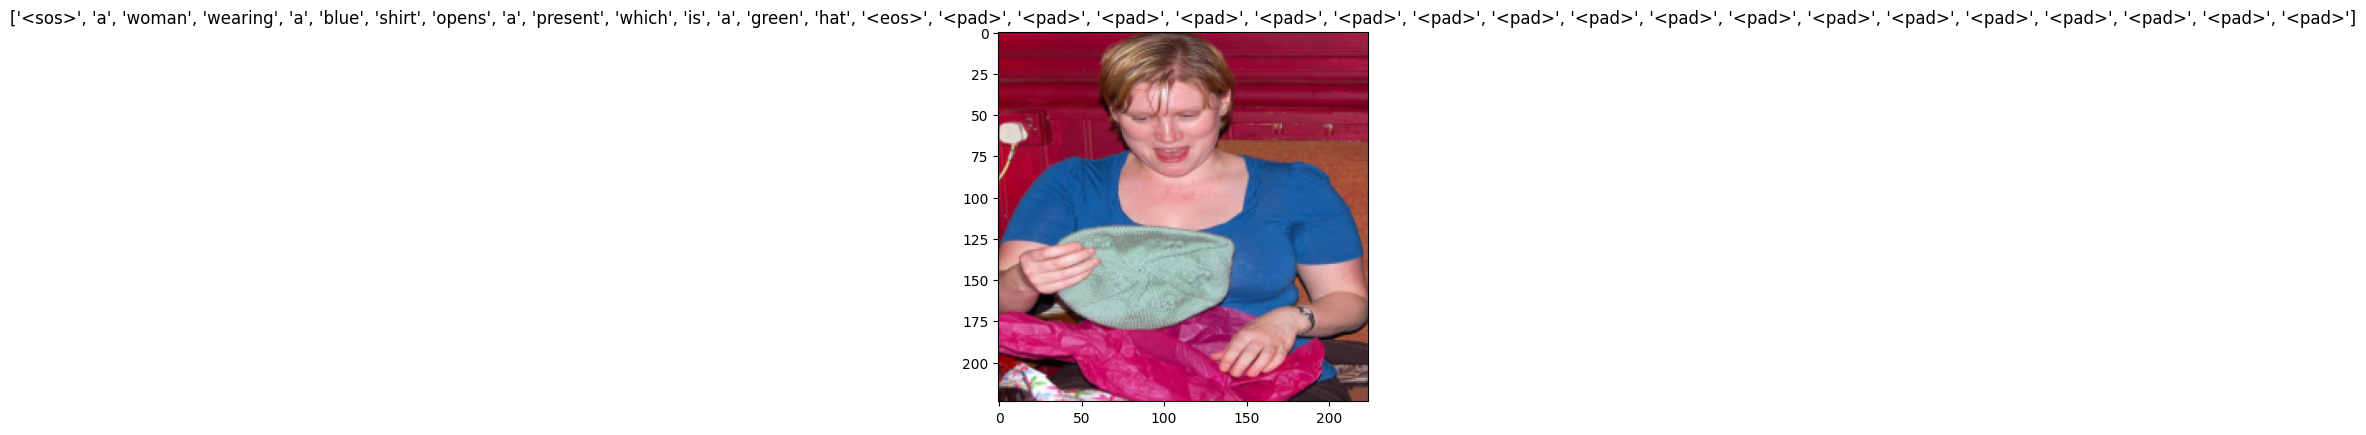

<sos> the <unk> bird flies low over the water <eos>
<sos> a white bird <unk> above the water <eos>
<sos> a white crane flies over water <eos>
<sos> a white bird flies over a lake <eos>
<sos> a bird flies across the water <eos>


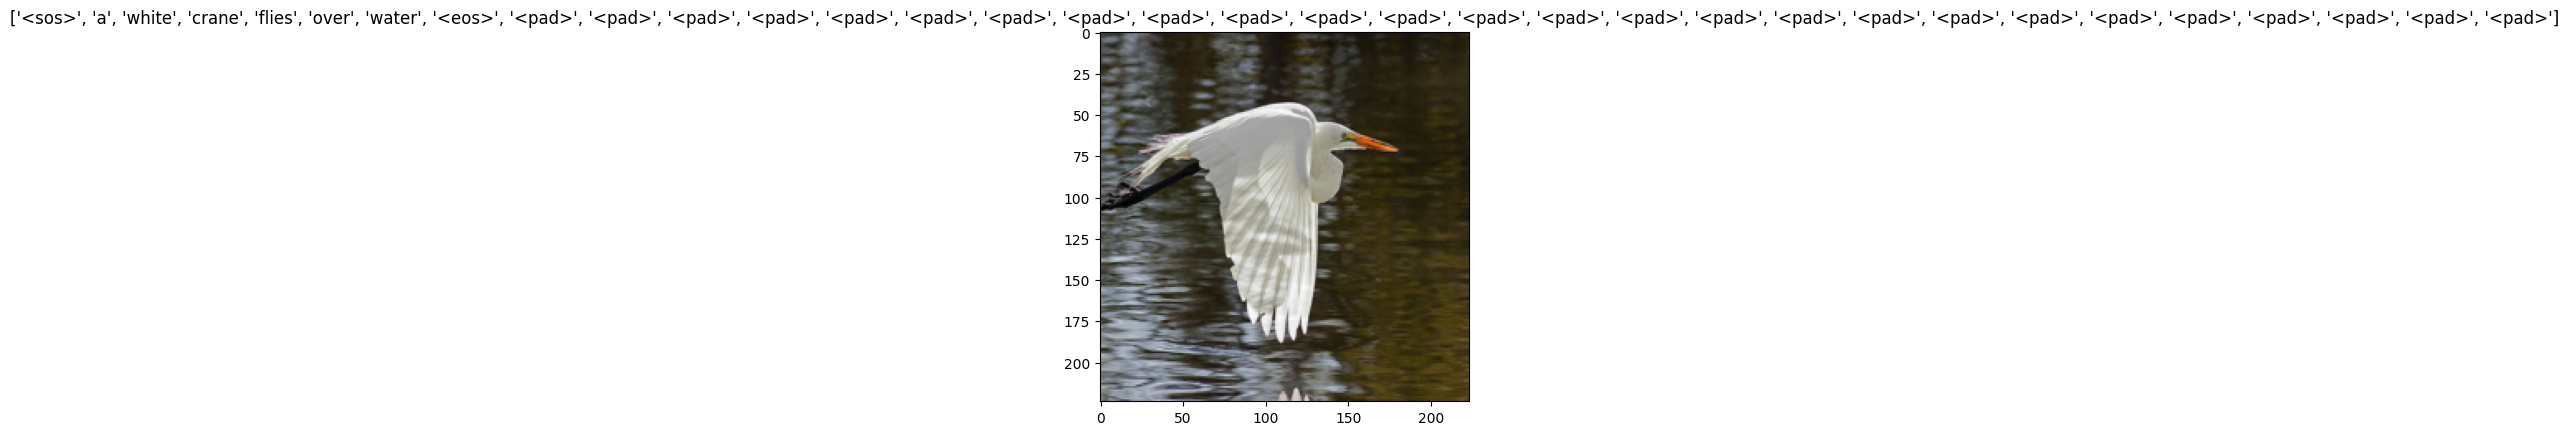

In [ ]:
# some examples from validation set
i= 0
x, y,l,a = next(iter(val_loader))
for image, caption,length,all_caps in zip(x, y,l,a):
    image = denormalize(image)
    caption = [vocab.idx_to_word(int(word_id)) for word_id in caption]
    plt.imshow(image)
    plt.title(caption)
    for c in all_caps:
        c_sentence = [vocab.idx_to_word(int(word_id)) for word_id in c if word_id!=0]
        c_sentence = ' '.join(word for word in c_sentence)
        print(c_sentence)
    plt.show()
    plt.pause(1)
    i+=1
    if i ==3:
        break

### Training Model (without fine tuning Encoder)

In [ ]:
embed_dim = 512
attention_dim = 512
decoder_dim = 512
encoder_dim = 2048
encoder_lr = 1e-4
decoder_lr = 4e-4
grad_clip = 5.
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
vocab_size = 10000
best_bleu4 = 0.
lr_decay_factor = 0.8
lr_decay_patience = 8
best_bleu4 = 0
patience = 6
model_file = '/content/drive/MyDrive/AppliedDeepLearning/image_captioning_best.pth'
file = '/content/drive/MyDrive/AppliedDeepLearning/model.csv'
num_epochs = 30
epochs_since_improvement = 0

fine_tune_encoder = False
checkpoint = None
if checkpoint is None:
        decoder = DecoderRNN(attention_dim,embed_dim,decoder_dim, vocab_size, encoder_dim)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

        encoder = EncoderCNN()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr) if fine_tune_encoder else None

else:
      checkpoint = torch.load(model_file)
      start_epoch = checkpoint['epoch'] + 1
      best_bleu4 = checkpoint['bleu-4']
      encoder = checkpoint['encoder']
      decoder = checkpoint['decoder']
      encoder_optimizer = checkpoint['encoder_optimizer']
      decoder_optimizer = checkpoint['decoder_optimizer']

encoder = encoder.to(device)
decoder = decoder.to(device)

encoder_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience) if fine_tune_encoder else None
decoder_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience)
criterion = nn.CrossEntropyLoss().to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.7MB/s]


In [ ]:
if checkpoint:
  start_epoch = checkpoint['epoch'] + 1
else:
  start_epoch = 1

for epoch in range(start_epoch,num_epochs+1):
  start = time.time()
  loss_train = train(train_loader,encoder,decoder,criterion, encoder_optimizer, decoder_optimizer,device,grad_clip,alpha_c)
  loss_val,bleu1_val, bleu2_val,bleu3_val,bleu4_val = validate(val_loader, encoder, decoder, criterion,device,alpha_c)

  decoder_lr_scheduler.step(bleu4_val)
  if fine_tune_encoder:
          encoder_lr_scheduler.step(bleu4_val)

  is_best = bleu4_val > best_bleu4
  if bleu4_val > best_bleu4:
    best_bleu4 = bleu4_val
    patience = 6

  else :
    patience -=1


  if patience <= 0:
    print('Triggering early stopping')
    break

  print('-' * 40)
  print(f'epoch: {epoch}, train loss: {loss_train:.4f}, valid loss: {loss_val:.4f},BLEU-1 {bleu1_val:.4f}, BLEU-2 {bleu2_val:.4f},BLEU-3 {bleu3_val:.4f} ,BLEU-4 {bleu4_val},best BLEU-4: {best_bleu4:.4f}')
  print(f'Time needed for epoch {epoch}', time.time()- start)
  print('-' * 40)
  d = {'epoch':epoch ,'train loss': loss_train, 'valid loss': loss_val,'bleu1': bleu1_val , 'bleu2': bleu2_val, 'bleu3': bleu3_val,'bleu4':bleu4_val,'best bleu4':best_bleu4 }

  with open(file,'a') as f:
        dictwriter_object = DictWriter(f, fieldnames=['epoch','train loss','valid loss','bleu1','bleu2','bleu3','bleu4','best bleu4'])
        dictwriter_object.writerow(d)
  save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, bleu4_val, is_best,model_file)



  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 1, train loss: 5.4182, valid loss: 4.9409,BLEU-1 0.5380, BLEU-2 0.3316,BLEU-3 0.1955 ,BLEU-4 0.11845547983024622,best BLEU-4: 0.1185
Time needed for epoch 1 6082.387575626373
----------------------------------------
Saving the best model


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 2, train loss: 4.9274, valid loss: 4.8012,BLEU-1 0.5452, BLEU-2 0.3398,BLEU-3 0.2028 ,BLEU-4 0.12376219555837939,best BLEU-4: 0.1238
Time needed for epoch 2 1629.1885511875153
----------------------------------------
Saving the best model


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 3, train loss: 4.7617, valid loss: 4.7596,BLEU-1 0.5478, BLEU-2 0.3439,BLEU-3 0.2068 ,BLEU-4 0.12686036312253723,best BLEU-4: 0.1269
Time needed for epoch 3 1603.3250951766968
----------------------------------------
Saving the best model


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 4, train loss: 4.6505, valid loss: 4.7363,BLEU-1 0.5505, BLEU-2 0.3471,BLEU-3 0.2113 ,BLEU-4 0.13022902622781649,best BLEU-4: 0.1302
Time needed for epoch 4 1640.1653277873993
----------------------------------------
Saving the best model


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 5, train loss: 4.5626, valid loss: 4.7087,BLEU-1 0.5484, BLEU-2 0.3448,BLEU-3 0.2086 ,BLEU-4 0.12859062797986068,best BLEU-4: 0.1302
Time needed for epoch 5 1641.5140807628632
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 6, train loss: 4.4880, valid loss: 4.7072,BLEU-1 0.5500, BLEU-2 0.3440,BLEU-3 0.2066 ,BLEU-4 0.1253489959536208,best BLEU-4: 0.1302
Time needed for epoch 6 1697.8733170032501
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 7, train loss: 4.4239, valid loss: 4.7093,BLEU-1 0.5524, BLEU-2 0.3498,BLEU-3 0.2128 ,BLEU-4 0.13103008243721606,best BLEU-4: 0.1310
Time needed for epoch 7 1854.6262984275818
----------------------------------------
Saving the best model


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 8, train loss: 4.3716, valid loss: 4.7006,BLEU-1 0.5517, BLEU-2 0.3486,BLEU-3 0.2116 ,BLEU-4 0.1302839126534568,best BLEU-4: 0.1310
Time needed for epoch 8 1621.975333929062
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 9, train loss: 4.3297, valid loss: 4.6897,BLEU-1 0.5539, BLEU-2 0.3505,BLEU-3 0.2138 ,BLEU-4 0.1322227043908643,best BLEU-4: 0.1322
Time needed for epoch 9 1652.2339944839478
----------------------------------------
Saving the best model


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 10, train loss: 4.2849, valid loss: 4.7163,BLEU-1 0.5511, BLEU-2 0.3470,BLEU-3 0.2104 ,BLEU-4 0.12999864413076245,best BLEU-4: 0.1322
Time needed for epoch 10 1693.7951276302338
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 11, train loss: 4.2417, valid loss: 4.7201,BLEU-1 0.5500, BLEU-2 0.3455,BLEU-3 0.2096 ,BLEU-4 0.12950847602488946,best BLEU-4: 0.1322
Time needed for epoch 11 1717.154352903366
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 12, train loss: 4.2050, valid loss: 4.7510,BLEU-1 0.5486, BLEU-2 0.3440,BLEU-3 0.2077 ,BLEU-4 0.12662365926976907,best BLEU-4: 0.1322
Time needed for epoch 12 1834.875066280365
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 13, train loss: 4.1744, valid loss: 4.7306,BLEU-1 0.5492, BLEU-2 0.3442,BLEU-3 0.2089 ,BLEU-4 0.12833799425436065,best BLEU-4: 0.1322
Time needed for epoch 13 1629.7130181789398
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 14, train loss: 4.1434, valid loss: 4.7505,BLEU-1 0.5476, BLEU-2 0.3411,BLEU-3 0.2044 ,BLEU-4 0.12464673093619542,best BLEU-4: 0.1322
Time needed for epoch 14 1654.07155251503
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

Triggering early stopping


In [8]:
#add header to csv
df = pd.read_csv('model.csv')
df.columns = ['epoch', 'train loss','val loss','BLEU-1','BLEU-2','BLEU-3','BLEU-4','BEST BLEU-4']
df.to_csv('model.csv')

### Evaluating on Test Set

In [8]:
checkpoint = torch.load('/content/drive/MyDrive/AppliedDeepLearning/image_captioning_best.pth')
start_epoch = checkpoint['epoch'] + 1
best_bleu4 = checkpoint['bleu-4']
encoder = checkpoint['encoder'].to(device)
decoder = checkpoint['decoder'].to(device)
encoder_optimizer = checkpoint['encoder_optimizer']
decoder_optimizer = checkpoint['decoder_optimizer']
criterion = nn.CrossEntropyLoss().to(device)
alpha_c = 1.

In [11]:
bleu1_test, bleu2_test,bleu3_test,bleu4_test = evaluate_test(test_loader,encoder, decoder, criterion,device,alpha_c)


  0%|          | 0/157 [00:00<?, ?it/s]

In [12]:
print(f'Metrics on Test Set BLEU-1 {bleu1_test:.4f}, BLEU-2 {bleu2_test:.4f},BLEU-3 {bleu3_test:.4f} ,BLEU-4 {bleu4_test}')

Metrics on Test Set BLEU-1 0.5546, BLEU-2 0.3482,BLEU-3 0.2112 ,BLEU-4 0.1293481023254021
